# Analyze nuclei of suspended MDCK for Figure 4b
Data: reconstructed 3D blue channel image of suspended MDCK  
      id551_MDCK_cellonly_01_300Hz_405_250mW_488_150mW_405.npy

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from skimage.measure import regionprops_table, marching_cubes, mesh_surface_area
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage.filters import unsharp_mask

from cellpose import models, core
from cellpose import plot

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

>>> GPU activated? 1
2023-04-27 20:47:45,801 [INFO] WRITING LOG OUTPUT TO /home/minato/.cellpose/run.log


## Functions

In [1]:
def segment(data, suffix):
    '''
    Segment nuclei

    data: name of the input data
    suffix: suffix of the input data
    '''
    res = []
    for s in suffix:
        print(s)
        img = np.load(f'../result/{data}{s}.npy')
        if s == '_X5':
            img = img[..., :1315]
        img = img[10:60, 10:630, 40: img.shape[2]-35]
        img = (img - img.min()) / (img.max() - img.min())
        img = unsharp_mask(img, radius=5, amount=10)

        model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
        channels = [0,0]
        masks, flows, styles, _ = model.eval(img, channels=channels, diameter=17, do_3D=True)
        res.append(masks)

    return res

In [4]:
def calculate_props(segmented, scale=(None, None, None)):
    '''
    Calculate morphological properties of nuclei

    segmented: label image after segmentation
    scale: pixel resolution in um scale
    '''
    res = []
    surface = []
    
    for data in segmented:
        data = clear_border(data) # remove objects on the edge
        data = remove_small_objects(data, min_size=125) # remove small objects

        # calculate properties
        props = pd.DataFrame(regionprops_table(data, properties=('label', 'area', 'axis_major_length', 'axis_minor_length', 'solidity', 'bbox'),
                                           spacing=scale))
        props = props.rename(columns={'area': 'Volume', 'axis_major_length': 'Major axis length', 'axis_minor_length': 'Minor axis length', 'solidity': 'Solidity'})
        props['Aspect ratio'] = props['Major axis length']/props['Minor axis length']
        res.append(props)
        
        for i, row in props.iterrows():
            label = row['label']
            bbox = np.array((row['bbox-0'], row['bbox-3'], row['bbox-1'], row['bbox-4'], row['bbox-2'], row['bbox-5']), dtype='uint64')
            labelled_object = data[bbox[0]:bbox[1], bbox[2]:bbox[3], bbox[4]:bbox[5]]
            labelled_object = np.where(labelled_object==label, True, False)

            verts, faces, _, _ = marching_cubes(labelled_object, spacing=scale)
            surface.append(mesh_surface_area(verts, faces))
        
    res = pd.concat(res)
    res = res.reset_index(drop=True)
    res['label'] = np.arange(1, len(res)+1)
    
    res['Surface area'] = surface
    res['Surface-to-Volume'] = surface/res['Volume']
    
    return res

## Parameters

In [3]:
suffix = ['', '_X1', '_X2', '_X3', '_X4', '_X5']
scale = np.repeat(0.295*4, 3) # spatial resolution in um scale

NameError: name 'np' is not defined

## Analysis

### Measurement: 1

In [4]:
data = 'id551_MDCK_cellonly_01_300Hz_405_250mW_488_150mW_405'

In [5]:
res = segment(data, suffix)


2023-04-27 20:48:14,248 [INFO] ** TORCH CUDA version installed and working. **
2023-04-27 20:48:14,252 [INFO] >>>> using GPU
2023-04-27 20:48:14,254 [INFO] >> nuclei << model set to be used
2023-04-27 20:48:14,429 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-04-27 20:48:14,432 [INFO] ~~~ FINDING MASKS ~~~
2023-04-27 20:48:14,544 [INFO] multi-stack tiff read in as having 50 planes 1 channels
2023-04-27 20:48:21,649 [INFO] running YX: 50 planes of size (620, 2715)
2023-04-27 20:48:55,860 [INFO] 100%|##########| 50/50 [00:33<00:00,  1.48it/s]
2023-04-27 20:48:59,078 [INFO] running ZY: 620 planes of size (50, 2715)
2023-04-27 20:49:34,611 [INFO] 100%|##########| 310/310 [00:34<00:00,  8.88it/s]
2023-04-27 20:49:39,218 [INFO] running ZX: 2715 planes of size (50, 620)
2023-04-27 20:50:21,966 [INFO] 100%|##########| 340/340 [00:42<00:00,  8.08it/s]
2023-04-27 20:50:28,034 [INFO] network run in 132.52s
2023-04-27 20:52:20,233 [INFO] masks created in 

In [6]:
for i in res:
    print(np.unique(i))

[   0    1    2 ... 3490 3491 3492]
[   0    1    2 ... 4133 4134 4135]
[   0    1    2 ... 4425 4426 4427]
[   0    1    2 ... 4221 4222 4223]
[   0    1    2 ... 4711 4712 4713]
[   0    1    2 ... 2141 2142 2143]


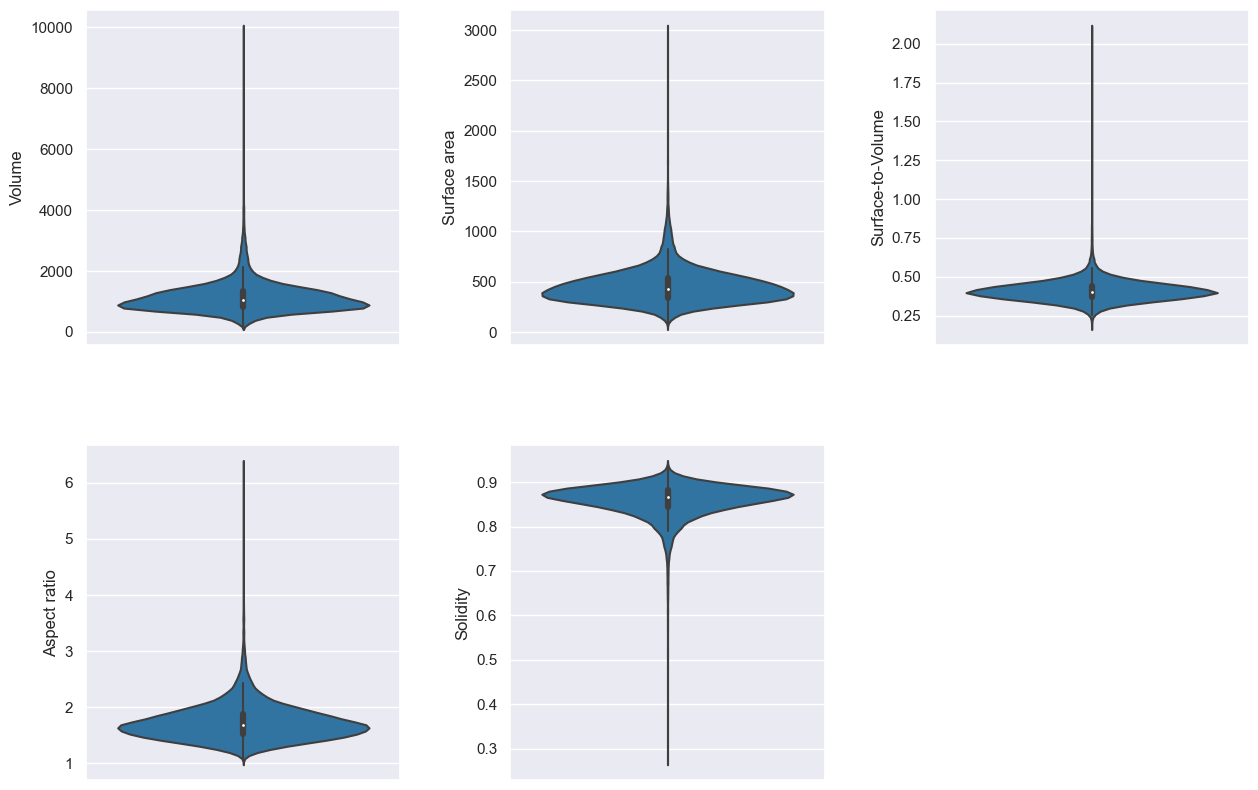

In [9]:
sns.set_style('darkgrid')
sns.set_context('notebook')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns = ['Volume', 'Surface area', 'Surface-to-Volume', 'Aspect ratio', 'Solidity']

for i, ax in enumerate(axes):
    if i == 5:
        axes[i].set_axis_off()
    else:
        sns.violinplot(data=res_props, y=columns[i], ax=ax)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
#plt.suptitle(f'Morphological properties of nucleus n={n_adhered}(adhered), {n_suspended}(suspended)', y=0.95, size=20)

In [10]:
res_props.to_csv('../result/suspended_1_props.csv')